In [1]:
# inspired by https://www.tensorflow.org/alpha/tutorials/generative/pix2pix

In [2]:
import tensorflow as tf
tf.enable_eager_execution()

In [42]:
from tensorflow.python import roll as _roll
from tensorflow.python.framework import ops
import numpy as np
from astropy.io import fits
import os
import time
from pathlib import Path
import matplotlib.pyplot as plt
from IPython.display import clear_output
from io import BytesIO

In [43]:
%matplotlib inline

In [44]:
PATH = Path("/scratch/datasets/astro_deconv_2019_split/")
BUFFER_SIZE = 400
BATCH_SIZE = 1
IMG_SIZE = 256/2
OUTPUT_CHANNELS = 1
LAMBDA = 100
EPOCHS = 200

In [45]:
def landman_convolve(arr1, arr2):
    # dim 2> probably crashes kernel
    assert(arr1.ndim == 2)
    assert(arr2.ndim == 2)
    def myFs(img):
        axes = tuple(range(img.ndim))
        shift = [dim // 2 for dim in img.shape]
        return _roll(img, shift, axes)
    def myiFs(img):
        axes = tuple(range(img.ndim))
        shift = [-(int(dim) // 2) for dim in img.shape]
        return _roll(img, shift, axes)

    arr1hat = tf.signal.rfft2d(myiFs(arr1))
    arr2hat = tf.signal.rfft2d(myiFs(arr2))
    return myFs(tf.signal.irfft2d(tf.multiply(arr1hat, arr2hat)))

In [46]:
def fits_open(path):
    content = fits.open(str(path))[0].data.squeeze().astype(np.float32)
    if IMG_SIZE == 128:
        return content[64:-64, 64:-64]
    else:
        return content

In [47]:
def load_fits(fits_file):
    def internal(data):
        return fits.open(BytesIO(data))[0].data.squeeze().astype(np.float32)[..., np.newaxis]
    blob = tf.io.read_file(fits_file)
    return tf.py_func(internal, [blob], tf.float32)

In [48]:
def make_dataset(glob):
    ds = tf.data.Dataset.list_files(str(glob), shuffle=False)
    ds = ds.map(load_fits)
    return ds

In [49]:
def normalize(first, *others):
    """accepts a list of images, normalized to [-.8, .8] relative to the first image"""
    min_ = tf.reduce_min(first)
    max_ = tf.reduce_max(first)
    f = lambda i: ((i - min_) / ((max_ - min_)/1.6)) - 0.8
    return [min_, max_, f(first)] + list(map(f, others))

In [51]:
def random_jitter(*images):
    if (tf.random.uniform(shape=()) > tf.to_float(0.5))  is not None:
        return [tf.image.flip_left_right(i) for i in images]
    else:
        return list(images)    

In [71]:
def downsample(filters, size, apply_batchnorm=True):
    #https://stackoverflow.com/questions/37092037/tensorflow-what-does-tf-nn-separable-conv2d-do
    
    #type_ = tf.keras.layers.DepthwiseConv2D
    type_ = tf.keras.layers.Conv2D
    
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(type_(filters,
                     size,
                     strides=2,
                     padding='same',
                     kernel_initializer=initializer,
                     use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result

In [53]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
          result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

In [54]:
def Generator():
    if IMG_SIZE == 256:
        down_stack_start = [
            downsample(64, 4, apply_batchnorm=False), # (bs, 128, 128, 64)
            downsample(128, 4), # (bs, 64, 64, 128)
        ]
    elif IMG_SIZE == 128:
        down_stack_start = [
            downsample(128, 4, apply_batchnorm=False), # (bs, 64, 64, 128)
        ]
    else:
        raise Exception

    down_stack = down_stack_start + [
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
    ]

    if IMG_SIZE == 256:        
        up_stack.append(upsample(64, 4)) # (bs, 128, 128, 128)
    elif IMG_SIZE == 128:
        # do nothing
        ...
    else:
        raise Exception
    
    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                           strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh') # (bs, IMG_SIZE, IMG_SIZE, 1)

    concat = tf.keras.layers.Concatenate()

    inputs = tf.keras.layers.Input(shape=[None,None,1])
    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = concat([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [55]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=[None, None, 1], name='input_image')
    tar = tf.keras.layers.Input(shape=[None, None, 1], name='target_image')

    x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, channels*2)

    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)

In [56]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss

In [57]:
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    total_gen_loss = gan_loss + (LAMBDA * l1_loss)
    return total_gen_loss

In [58]:
def convolve(convolved, convolver):
    return landman_convolve(tf.squeeze(convolved), tf.squeeze(convolver))
    #kernel = tf.squeeze(convolver)[:, :, tf.newaxis, tf.newaxis]
    #return tf.nn.conv2d(convolved, kernel, [1, 1, 1, 1], "SAME")

In [59]:
def like_loss(predicted, target, psf):
    convolved = convolve(predicted, psf)
    return tf.reduce_sum(tf.multiply(predicted, convolved - 2 * target)) 

In [60]:
def clean_loss(predicted, target, clean_beam):
    return l1(convolve(predicted, clean_beam), convolve(target, clean_beam))

In [61]:
def generate_images(prediction, test_input, tar):
    plt.figure(figsize=(15,15))

    display_list = [test_input, tar, prediction]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        ax = plt.imshow(tf.squeeze(display_list[i]))
        plt.axis('off')
        plt.colorbar()
    plt.show()

In [62]:
def train_step(input_image, target):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)
        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)
        gen_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

In [80]:
def train_step_likelyhood(input_image, target, psf):
    
    # todo: add psf as channel
    #combi  = tf.concat([input_image, psf], axis=3)
    combi = input_image
    
    with tf.GradientTape() as gen_tape:
        gen_output = generator(combi, training=True)
        gen_loss = like_loss(gen_output, target, psf)

    generator_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))

In [81]:
def train_step_cleanbeam(input_image, target, clean_beam):
    with tf.GradientTape() as gen_tape:
        gen_output = generator(input_image, training=True)
        gen_loss = clean_loss(gen_output, target, clean_beam)

    generator_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))

In [82]:
def l1(a, b):
    return tf.math.reduce_sum(tf.math.abs(a - b))

In [83]:
scores = []
def train(train_dataset, test_dataset, epochs):
    for epoch in range(epochs):
        step = 0
        start = time.time()

        for input_, target, psf, bigpsf, clean_beam in train_dataset:
            min_, max_, input_, target, = normalize(input_, target)
            
            ## here you can change the loss method
            train_step(input_, target)
            #train_step_likelyhood(input_, target, psf)
            #rain_step_cleanbeam(input_, target, clean_beam)
            
            
            step += 1

            test_interval = 30
            if (step + 1) % test_interval == 0:
                clear_output(wait=True)
                for test_input, test_target, psf, clean_beam, wsclean in test_dataset.take(1):
                
                    r = normalize(test_input, test_target, clean_beam, wsclean)
                    min_, max_, test_input, test_target, clean_beam, wsclean = r

                    # the training=True is intentional here since
                    # we want the batch statistics while running the model
                    # on the test dataset. If we use training=False, we will get
                    # the accumulated statistics learned from the training dataset
                    # (which we don't want)
                    prediction = generator(test_input, training=True)

                    generate_images(prediction, test_input, test_target)
                    clean_sky = convolve(target, clean_beam)
                    vacuum_l1 = l1(convolve(prediction, clean_beam), clean_sky)
                    wsclean_l1 = l1(convolve(wsclean, clean_beam),clean_sky )
                    scores.append(vacuum_l1)
                    print(f"l1 vacuum: {vacuum_l1.numpy()} wsclean: {wsclean_l1.numpy()}")

                    duration = time.time()-start
                    speed = step / duration
                    print(f"step: {step + 1} epoch: {epoch + 1} duration: {duration:.2f}s step/s: {speed:.2f}\n")
                    #for i in scores:
                    #    print(i)

        # saving (checkpoint) the model every 20 epochs
        if (epoch + 1) % 20 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
            


In [84]:
train_dirty_dataset = make_dataset(PATH / 'train/*-wsclean-dirty.fits')
train_skymodel_dataset = make_dataset(PATH / 'train/*-skymodel.fits')
train_psf_dataset = make_dataset(PATH / 'train/*-wsclean-psf.fits')
train_bigpsf_dataset = make_dataset(PATH / 'train/*-bigpsf-psf.fits')
train_clean_beam_dataset = make_dataset(PATH / 'train/*-clean-beam.fits')
train_dataset = tf.data.Dataset.zip((train_dirty_dataset, train_skymodel_dataset, train_psf_dataset, train_bigpsf_dataset, train_clean_beam_dataset))
train_dataset = train_dataset.map(random_jitter)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(1)

test_dirty_dataset = make_dataset(PATH / 'test/*-wsclean-dirty.fits')
test_wsclean_dataset = make_dataset(PATH / 'test/*-wsclean-model.fits')
test_skymodel_dataset = make_dataset(PATH / 'test/*-skymodel.fits')
test_psf_dataset = make_dataset(PATH / 'test/*-wsclean-psf.fits')
test_clean_beam_dataset = make_dataset(PATH / 'test/*-clean-beam.fits')

test_dataset = tf.data.Dataset.zip((test_dirty_dataset, test_skymodel_dataset, test_psf_dataset, test_clean_beam_dataset, test_wsclean_dataset))
test_dataset = test_dataset.shuffle(BUFFER_SIZE)
test_dataset = test_dataset.batch(1)

In [85]:
generator = Generator()
discriminator = Discriminator()
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
generator_optimizer = tf.train.AdamOptimizer(learning_rate=2e-4, beta1=0.5)
discriminator_optimizer = tf.train.AdamOptimizer(learning_rate=2e-4, beta1=0.5)

In [86]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator
                                )

# Train the shit

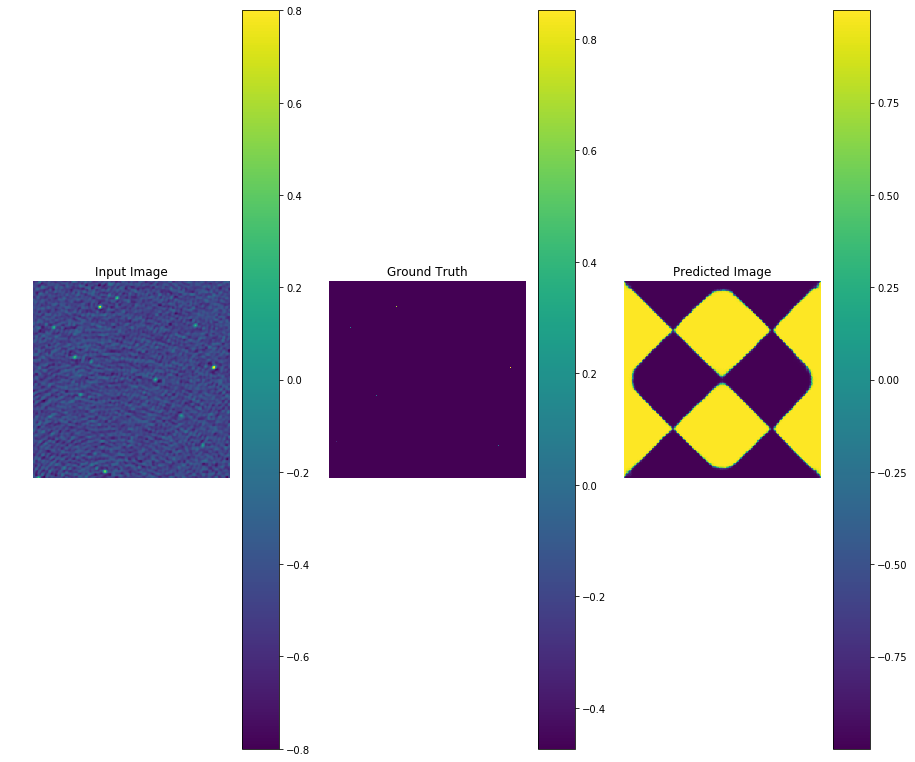

l1 vacuum: 1133886720.0 wsclean: 210033920.0
step: 240 epoch: 1 duration: 84.16s step/s: 2.84



In [ ]:
train(train_dataset, test_dataset, 1)

# manual trying out shit space

In [74]:
CheckpointLoadStatus = checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [78]:
test_input, test_target, psf, clean_beam, wsclean = list(test_dataset.take(1))[0]

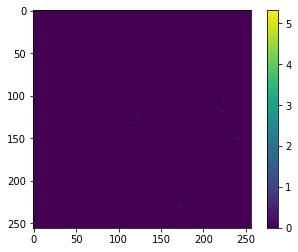

In [79]:
_ = plt.imshow(tf.squeeze(test_target))
_ = plt.colorbar()